In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.prop.Transformations import MagneticField, MagneticField2Magnetisation
from magrec.misc.data import Data
from magrec import __datapath__

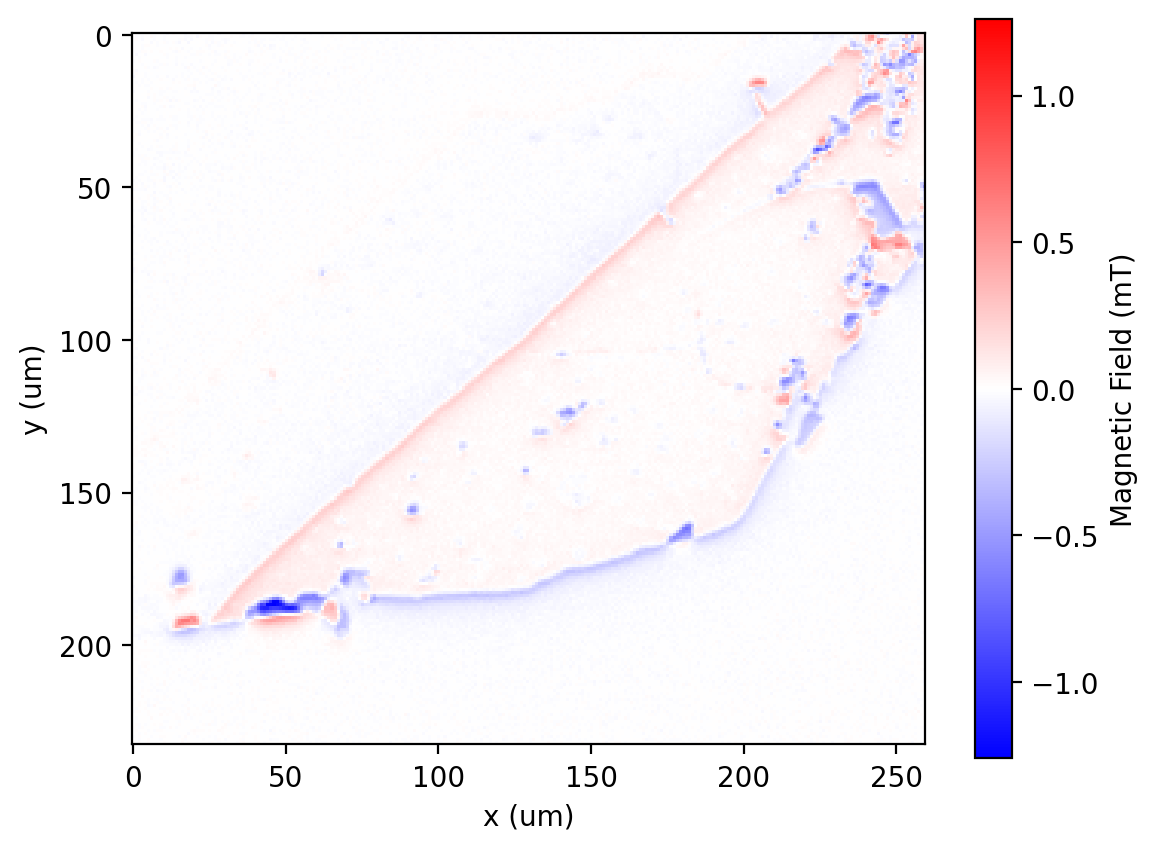

In [4]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

# dataset.define_pixel_size(dx, dy)

sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 90 

dataset = Data()
dataset.load_data(BNV, dx, dy, 0.05, sensor_theta, sensor_phi, 0)

dataset.remove_DC_background()
dataset.plot_target()


In [5]:
# Add filter 
dataset.add_hanning_filter(0.05)
dataset.add_hanning_filter(0.05)

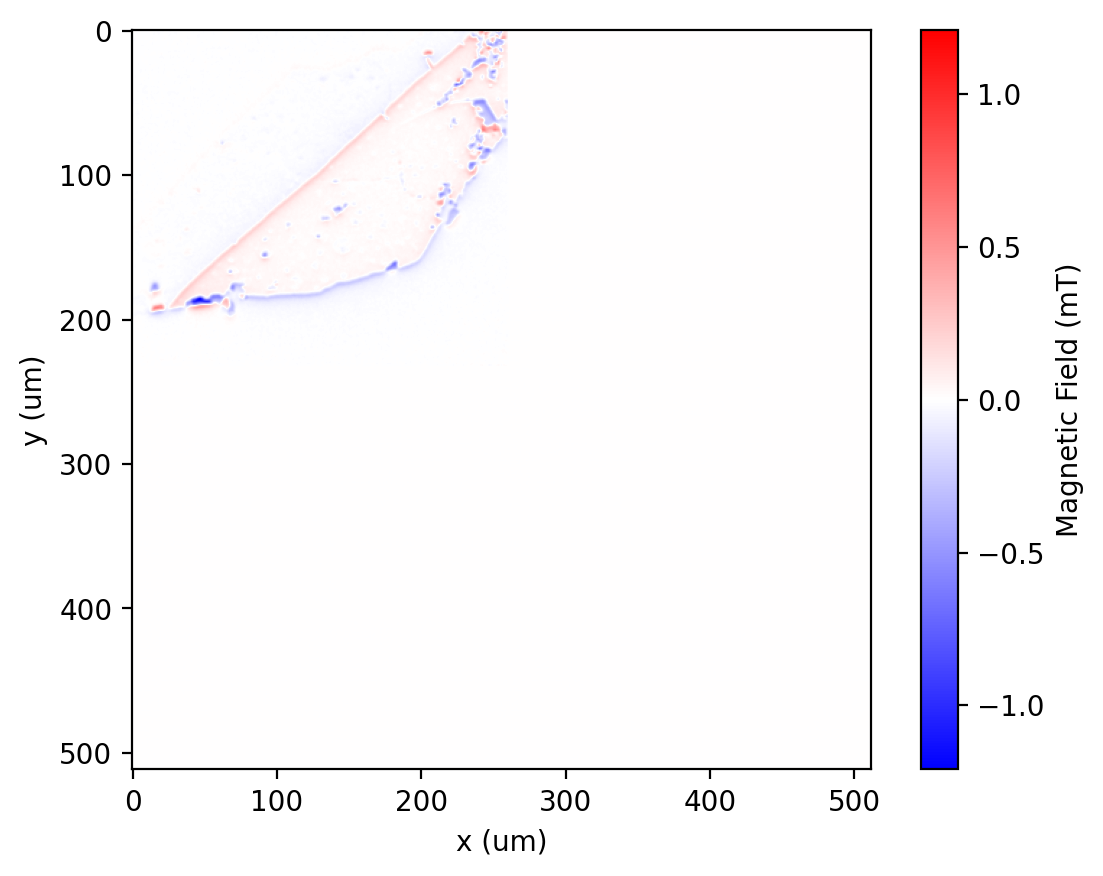

In [6]:
dataset.pad_data_to_power_of_two()
dataset.plot_target()

In [7]:
dataset.crop_data(dataset.reverse_parameters[-1])

dataset.actions


,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.05
3,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.05
4,pad_data,True,crop_data,Padded the data to a square image with dimensi...,None
5,crop_data,False,crop_data,crop the data with the given region of interest,"roi = [0,233,0,260,]"


# Transfor Bsensor into Bxyz

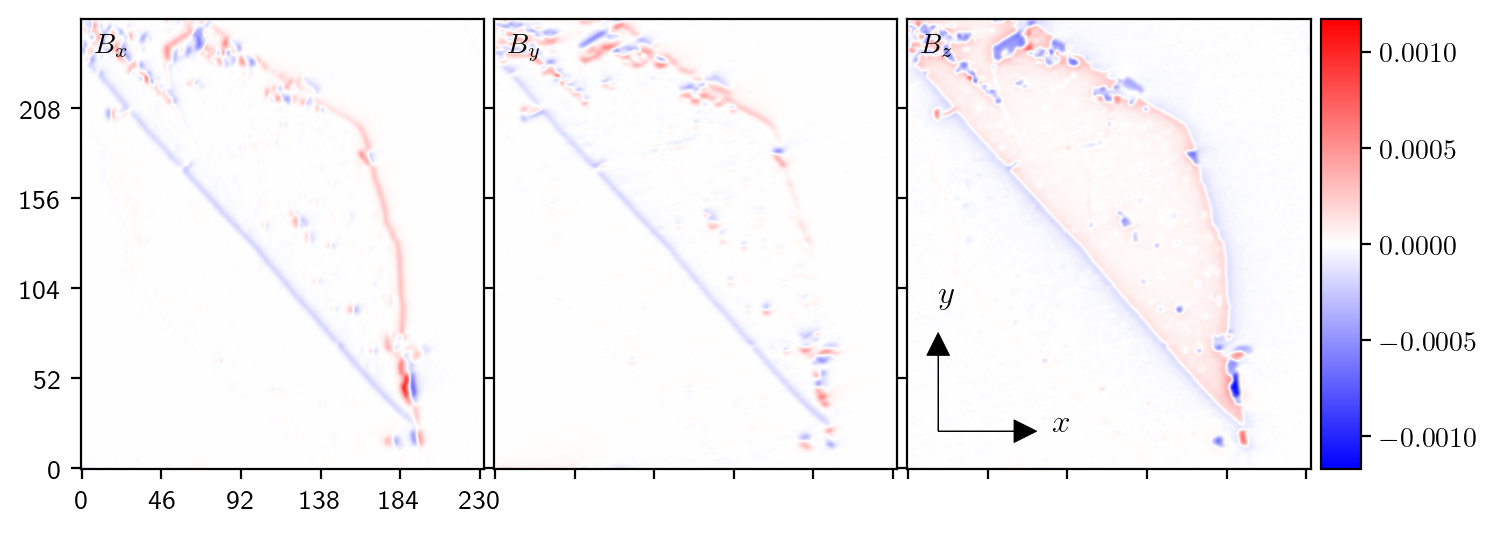

In [8]:
dataset.set_transformer(MagneticField)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

## Reconstruct the out of plane magnetisation using the B sensor

In [9]:
dataset2 = copy.deepcopy(dataset)

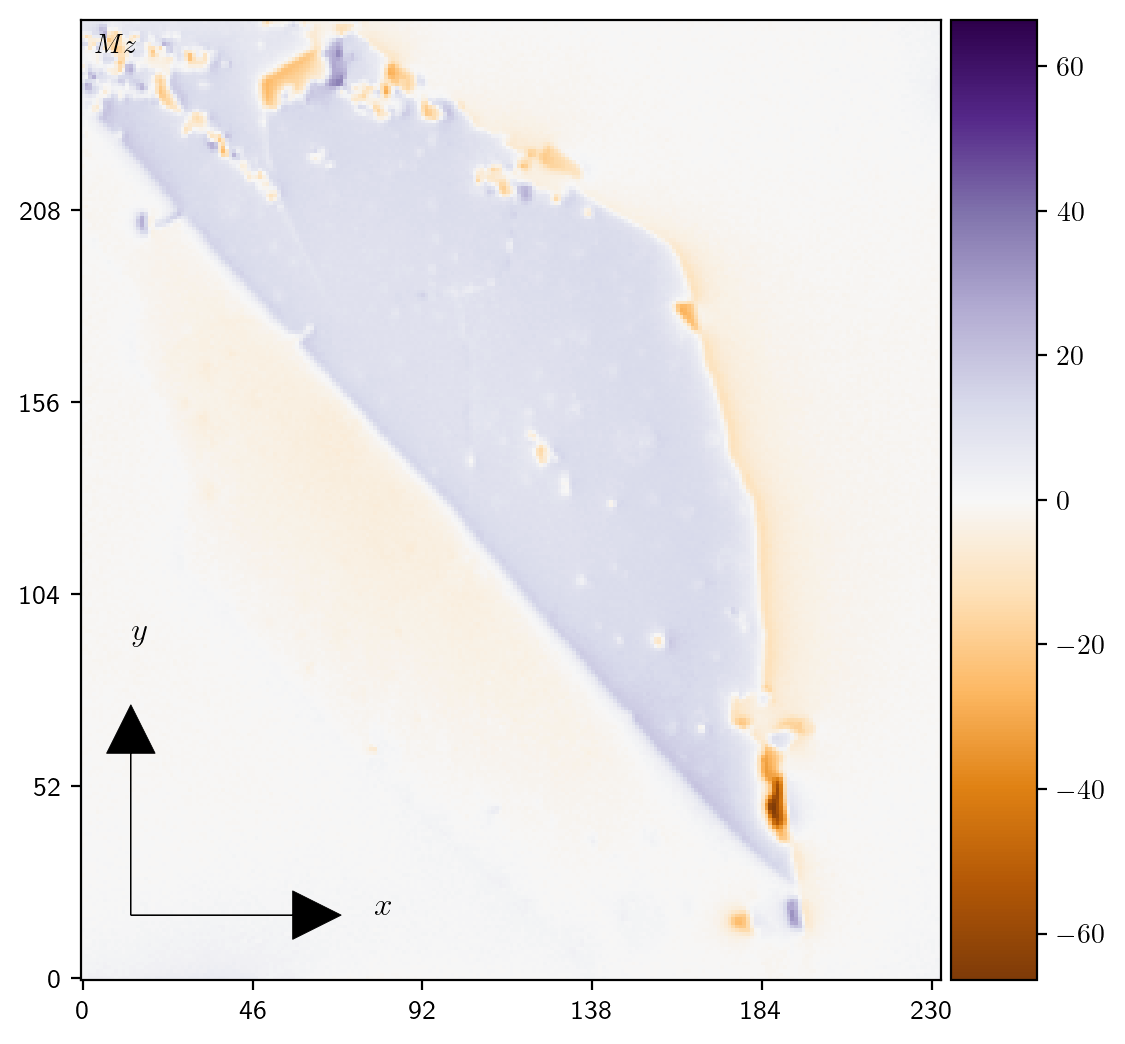

In [10]:
dataset2.set_transformer(MagneticField2Magnetisation, m_theta = 0, m_phi = 0)
dataset2.transform_data()

plot_n_components(
    -1*dataset2.transformed_target + 2, 
    symmetric=True, 
    labels=[r"$Mz$"], 
    cmap="PuOr")

## Reconstruct using only the Bz magnetic field component

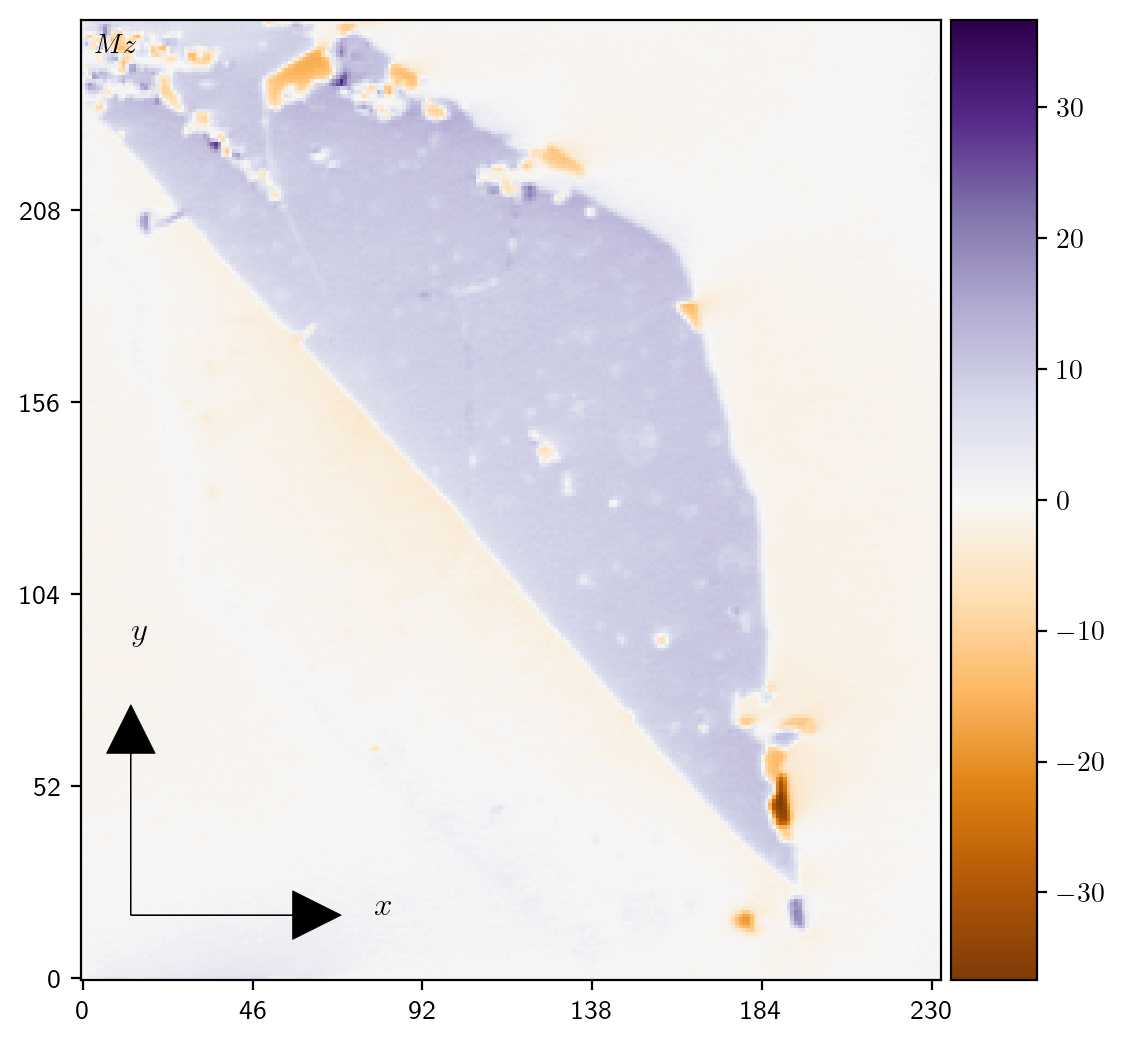

In [12]:
dataset3 = copy.deepcopy(dataset)
dataset3.target = dataset.transformed_target[2,::]
dataset3.define_sensor_angles(0, 0)
dataset3.set_transformer(MagneticField2Magnetisation, m_theta = 0, m_phi = 0)
dataset3.transform_data()

plot_n_components(
    -1*dataset3.transformed_target + 2, 
    symmetric=True, 
    labels=[r"$Mz$"], 
    cmap="PuOr")

## Now we will try to reconstruct the magnetisation using a neural network.

In [ ]:
from magrec.method.CNN import CNN

FittingMethod = 